In [9]:
import numpy as np
import scipy
import skfem    
#https://scikit-fem.readthedocs.io/en/latest/index.html

import matplotlib.pyplot as plt
#import importlib  # for reloading routines
%matplotlib inline


In [23]:
# routines that we will need here
from skfem.models.poisson import laplace, mass
#from scipy.sparse.linalg import splu

Solving the Laplaces equation in 2 d on a square with skfem
With both nonzero Neumann and Dirichlet boundary condtiions 
$$\Delta u =0$$
on the unit square with $u(x,y)$ with $x,y \in [0,1]$.
The square has top, bottom, and left, right boundaries. 

We are trying to set the top and bottom boundaries to $u=1$ and the left and right boundaries $\frac{\partial u}{\partial n} = 1$

The weak form 
\begin{align}
 0 = \int_\Omega (\partial_{xx} u) v dV 
 = - \int_\Omega  (\partial_x u) (\partial_x v ) dV  + \int_{\partial \Omega} (\partial_x  u) v  ds
 \end{align}
with $v \in H^1$ where $H^1$ is a Sobolev space. 
I kept the boundary term!



In [29]:

from skfem.helpers import dot, grad
m = skfem.MeshTri().refined(5)
e = skfem.ElementTriP1()
basis = skfem.Basis(m, e)
fbasis = skfem.FacetBasis(m,e)

@skfem.BilinearForm
def laplace(u, v, _):
    return skfem.helpers.dot(grad(u), grad(v))

@skfem.LinearForm
def rhs(v,_):
    return 1.0 * v

Dlr = basis.get_dofs({'left', 'right'})  # we don't use this for the Neumann boundary conditions (but why not?)
Dtb = basis.get_dofs({'top', 'bottom'})  # needed for Dirichlet boundary conditions 


In [13]:
m.boundaries['right']  # this is actually an array of locations 

array([  4,   8,  24,  25,  50,  51,  68,  69, 130, 131, 148, 149, 232,
       233, 236, 237, 434, 435, 452, 453, 536, 537, 540, 541, 672, 673,
       676, 677, 768, 769, 772, 773])

In [15]:
m.boundaries['left']

array([  1,   5,  14,  15,  36,  37,  54,  55, 116, 117, 134, 135, 176,
       177, 180, 181, 420, 421, 438, 439, 480, 481, 484, 485, 596, 597,
       600, 601, 692, 693, 696, 697])

In [17]:
Dlr.flatten()

array([  0,   1,   2,   3,   5,   7,  10,  13,  14,  17,  26,  29,  30,
        33,  39,  40,  49,  50,  82,  85,  86,  89,  95,  96, 105, 106,
       117, 118, 131, 132, 135, 136, 149, 150, 290, 293, 294, 297, 303,
       304, 313, 314, 325, 326, 339, 340, 343, 344, 357, 358, 405, 406,
       419, 420, 423, 424, 437, 438, 465, 466, 469, 470, 521, 522, 525,
       526])

In [19]:
Dlr

<skfem DofsView(MeshTri1, ElementTriP1) object>
  Number of nodal DOFs: 66 ['u']

<Axes: >

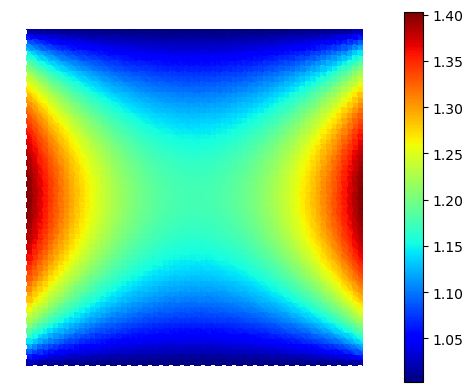

In [33]:
rbasis = skfem.FacetBasis(m, e, facets=m.boundaries['right'])   # joy! gives me facet basis for
# right boundary only?
lbasis = skfem.FacetBasis(m, e, facets=m.boundaries['left'])   # gives me facet basis for
# left boundary only

B = skfem.asm(rhs,rbasis) + skfem.asm(rhs,lbasis)    # operator on boundary using rhs linear op
A = skfem.asm(laplace,basis)  # laplacian op

u = basis.zeros()
u[Dtb] = 1.0  # we start with u satisfying our desired Dirichlet BC  on top/bottom boundaries 

x = skfem.solve(*skfem.condense(A, B, x=u, D=Dtb))  # solve!
from skfem.visuals.matplotlib import plot
skfem.visuals.matplotlib.plot(basis, x, colorbar=True)
# this looks ok 

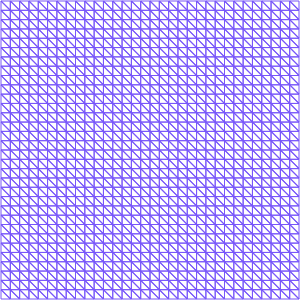

In [249]:
m  # our mesh

<Axes: >

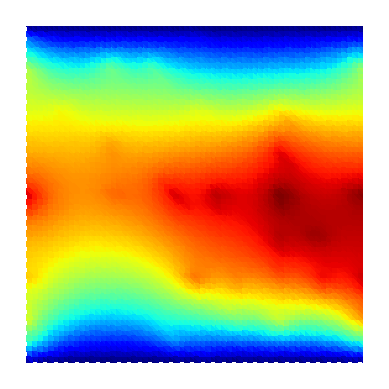

In [160]:

# below is incorrect but illustrates a bad way to try to solve the problem. 
#from skfem.helpers import dot, grad
m = skfem.MeshTri().refined(5)
e = skfem.ElementTriP1()
basis = skfem.Basis(m, e)
fbasis = skfem.FacetBasis(m,e)

@skfem.BilinearForm
def laplace(u, v, _):
    return skfem.helpers.dot(grad(u), grad(v))

@skfem.LinearForm
def rhs(v,_):
    return 1.0 * v

Dlr = basis.get_dofs({'left', 'right'})  
Dtb = basis.get_dofs({'top', 'bottom'})

fbasis = skfem.FacetBasis(m, e, facets=Dlr.flatten())   # this is wrong!
B = skfem.asm(rhs,fbasis)  
A = skfem.asm(laplace,basis)  # 

u = basis.zeros()
u[Dtb] = 1.0  # we start with u satisfying our desired Dirichlet BC 

x = skfem.solve(*skfem.condense(A, B, x=u, D=Dtb))
skfem.visuals.matplotlib.plot(basis, x)
# this is incorrect!